In [3]:
!pip install imblearn

     |████████████████████████████████| 206 kB 22.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [74]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from imblearn.pipeline import make_pipeline

from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, RandomOverSampler

%matplotlib inline

In [54]:
import os 
os.chdir("../")
bucket = 'aws-project-politomaster-sagemaker-data' 

In [55]:
prep_train_path = os.path.join('s3://', bucket, 'preprocess/prep_train.csv')
prep_train = pd.read_csv(prep_train_path)
print("Prep_train dataset has: {} rows and {} columns".format(prep_train.shape[0], prep_train.shape[1]))
prep_train.head()

Prep_train dataset has: 43170 rows and 10 columns


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,0,4,5,1,61.746807,54.834605,651.357414,5.350743,4.352193,2.667488
1,0,3,5,2,60.811398,60.300733,651.357414,5.350743,4.352193,2.667488
2,0,1,5,4,59.799569,60.300733,651.357414,5.350743,4.352193,2.667488
3,0,3,1,3,62.110048,57.770527,651.357414,5.350743,4.352193,2.667488
4,0,1,0,1,63.367713,58.202601,651.357414,5.350743,4.352193,2.899670


In [56]:
prep_test_path = os.path.join('s3://', bucket, 'preprocess/prep_test.csv')
prep_test = pd.read_csv(prep_test_path)
print("Prep_test dataset has: {} rows and {} columns".format(prep_test.shape[0], prep_test.shape[1]))
prep_train.head()

Prep_test dataset has: 10770 rows and 10 columns


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,0,4,5,1,61.746807,54.834605,651.357414,5.350743,4.352193,2.667488
1,0,3,5,2,60.811398,60.300733,651.357414,5.350743,4.352193,2.667488
2,0,1,5,4,59.799569,60.300733,651.357414,5.350743,4.352193,2.667488
3,0,3,1,3,62.110048,57.770527,651.357414,5.350743,4.352193,2.667488
4,0,1,0,1,63.367713,58.202601,651.357414,5.350743,4.352193,2.899670


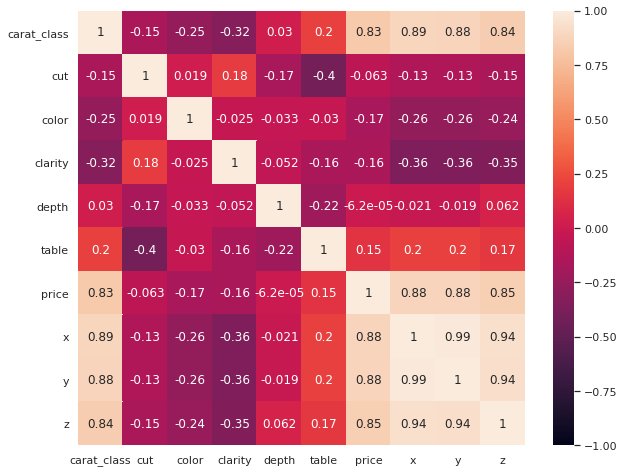

In [57]:
sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots(1, 1)
sns.heatmap(prep_train.corr(), vmin = -1, vmax= 1 , annot = True)
#plt.savefig("images/trainingCorr.png")
plt.show()

In [58]:
def categorize_x(x):
    to_return = None
    if x < 7:
        to_return = "low"
    elif x < 9:
        to_return = "medium"
    else:
        to_return = "high"
    return to_return

def categorize_y(y):
    to_return = None
    if y < 6:
        to_return = "low"
    elif y < 8:
        to_return = "medium"
    else:
        to_return = "high"
    return to_return

In [59]:
from sklearn.base import BaseEstimator,TransformerMixin

class CustomTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        print('>>>>>>>init() called.')
        
    def fit(self,X,y=None):
        #print('\n>>>>>>>fit() called.\n')
        return self
    
    def transform(self,X,y=None):
        #print('\n>>>>>>>transform() called.\n')
        X_ = X.copy()

        X_['x_cat'] = X_['x'].apply(lambda x : categorize_x(x)).astype(pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)).cat.codes
        X_['y_cat'] = X_['y'].apply(lambda y : categorize_y(y)).astype(pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)).cat.codes
        
        return X_
        

>>>>>>>init() called.


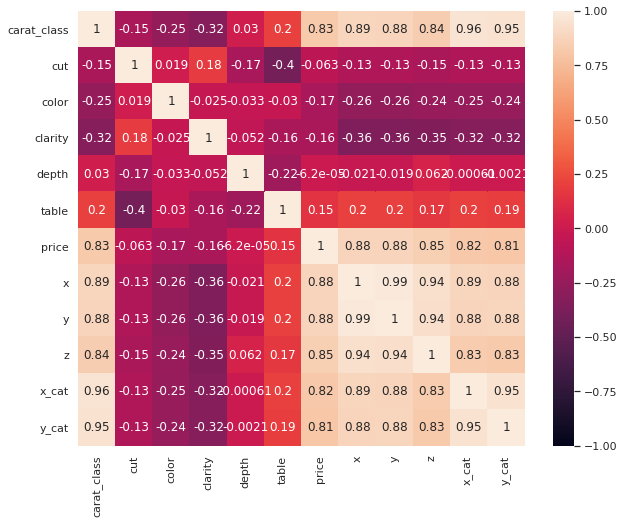

In [60]:
custom_transf = CustomTransformer()
new_train = custom_transf.transform(prep_train)

sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots(1, 1)
sns.heatmap(new_train.corr(), vmin = -1, vmax= 1 , annot = True)
#plt.savefig("images/trainingCorr.png")
plt.show()

In [61]:
seed = 0

target = prep_train['carat_class']
data = prep_train.drop(labels = ['carat_class'],axis = 1)
sample_train, sample_val, label_train, label_val = \
    train_test_split(data, target, test_size=0.3, random_state=seed)

In [62]:
sample_val

,cut,color,clarity,depth,table,price,x,y,z
13132,3,2,3,61.611695,58.906373,651.357414,5.350743,4.352193,2.667488
40381,2,3,1,61.500313,57.912615,2244.369628,6.745447,5.605625,3.509978
8316,1,3,2,59.799569,59.235267,4735.961619,7.569801,6.635349,3.456046
3175,4,6,2,61.911169,55.803287,3484.918109,6.646685,5.752120,3.853383
42756,2,3,2,62.214946,58.895610,2667.642756,6.903781,5.923935,3.654297
...,...,...,...,...,...,...,...,...,...
33971,2,6,1,59.844527,55.039473,3911.581104,6.096401,5.027781,3.219734
25585,4,3,4,61.400892,54.834605,751.989696,5.350743,4.352193,2.667488
5961,2,3,3,59.799569,60.300733,651.357414,5.573604,4.404508,2.698224
7915,4,5,1,61.364413,57.848705,4662.607883,7.535285,6.318069,4.044412


In [65]:
f1_list = []
accuracy_list = []
precision_list = []
recall_list = []

n_feature = len(sample_train.columns)
for feature_dim in range(1,n_feature+3):
    #feature_dim = 4
    """
    Perform PCA in order to reduce the dataset dimensionality.
    """
    custom_transf = CustomTransformer()
    std_scale = StandardScaler()
    pca = PCA(n_components=feature_dim)
    clf = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)


    t0 = time.time()
    model = make_pipeline(custom_transf,std_scale,pca,clf)
    model.fit(sample_train, label_train)
    pred = model.predict(sample_val)

    t1 = time.time()

    f1 = f1_score(label_val,pred,average = 'macro')
    max_err = max_error(label_val,pred)
    acc = accuracy_score(label_val,pred)
    precision = precision_score(label_val,pred,average = 'macro')
    recall = recall_score(label_val,pred,average = 'macro')
    print('PCA components: ',feature_dim)
    print('Time: ', t1-t0)
    
    f1_list.append(f1)
    accuracy_list.append(acc)
    precision_list.append(precision)
    recall_list.append(recall)
    
    print(classification_report(label_val,pred))
    print('\n')

>>>>>>>init() called.
PCA components:  1
Time:  11.708117485046387
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.97      0.99      0.98      4785
           2       0.97      0.90      0.93       564

    accuracy                           0.99     12951
   macro avg       0.98      0.96      0.97     12951
weighted avg       0.99      0.99      0.99     12951



>>>>>>>init() called.
PCA components:  2
Time:  4.188663005828857
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.97      0.99      0.98      4785
           2       0.97      0.89      0.93       564

    accuracy                           0.98     12951
   macro avg       0.98      0.95      0.97     12951
weighted avg       0.98      0.98      0.98     12951



>>>>>>>init() called.
PCA components:  3
Time:  3.5146052837371826
              precision    recall 

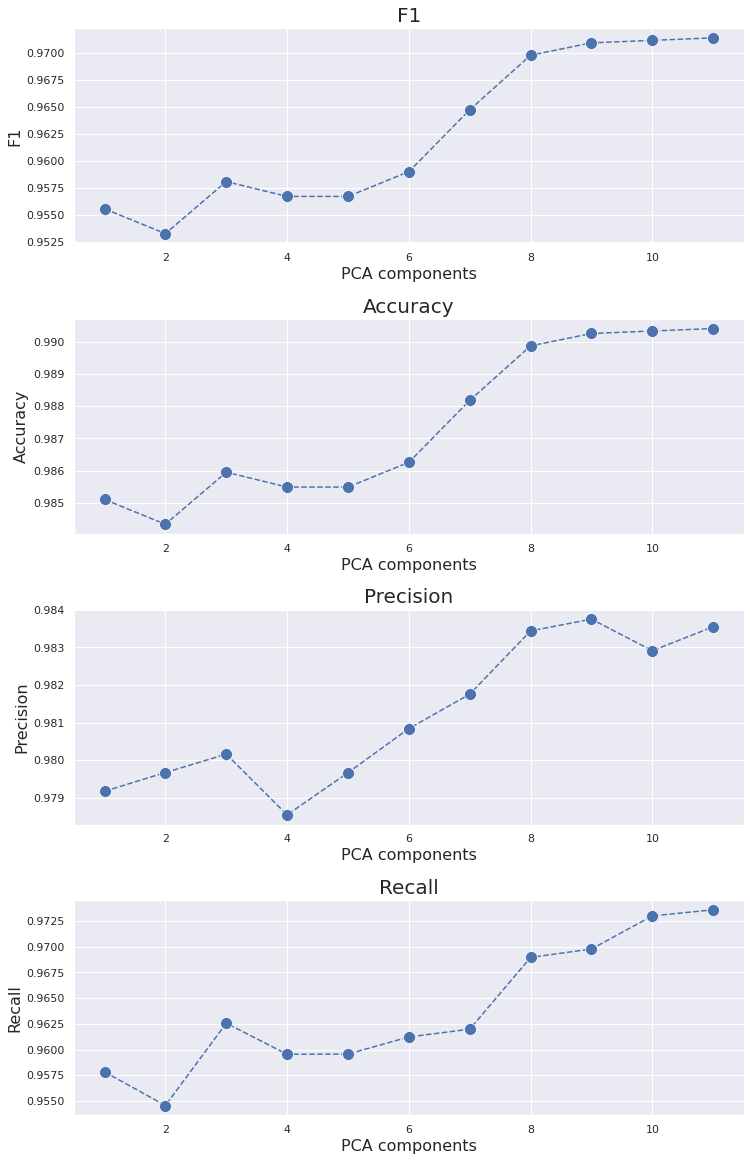

In [66]:
sns.set(rc={'figure.figsize':(12,20)})
sns.set_context("notebook", rc={"font.size":32,"axes.titlesize":20,"axes.labelsize":16})
fig, ax = plt.subplots(4,1)

for i,feature,result_list in zip(range(4),['F1','Accuracy','Precision','Recall'],
                                 [r2_list, accuracy_list,precision_list,recall_list]):
    sns.lineplot(x = range(1,12), y = result_list,
                 marker='o',markersize=12,linestyle='dashed', ax = ax[i])
    ax[i].set(ylabel=feature, xlabel='PCA components', title=feature)
    
plt.subplots_adjust(hspace = 0.35)
#plt.savefig("images/SparkLearningCurve.png")  
plt.show()

>>>>>>>init() called.
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7602
           1       0.98      0.99      0.99      4785
           2       0.97      0.94      0.95       564

    accuracy                           0.99     12951
   macro avg       0.98      0.97      0.98     12951
weighted avg       0.99      0.99      0.99     12951



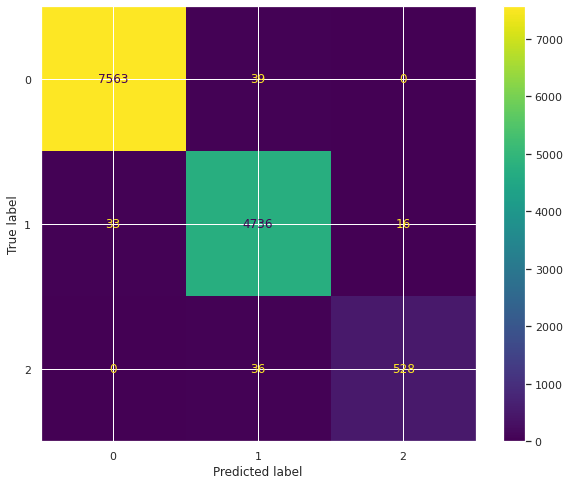

In [68]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
clf = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)

model = make_pipeline(custom_transf,std_scale,clf)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
print(classification_report(label_val,pred))

sns.set(rc={'figure.figsize':(10,8)})
plot_confusion_matrix(model, sample_val, label_val)  
plt.show()

>>>>>>>init() called.
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7602
           1       0.98      0.99      0.99      4785
           2       0.97      0.92      0.95       564

    accuracy                           0.99     12951
   macro avg       0.98      0.97      0.98     12951
weighted avg       0.99      0.99      0.99     12951



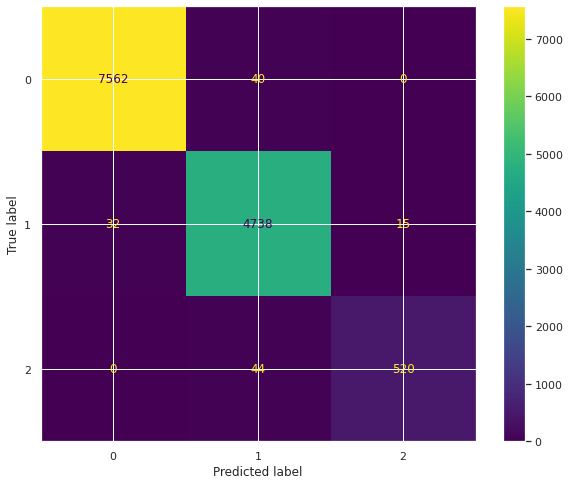

In [69]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)
clf = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)

model = make_pipeline(custom_transf,std_scale,pca,clf)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(10,8)})
plot_confusion_matrix(model, sample_val, label_val)  
plt.show()

>>>>>>>init() called.
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.99      0.98      4785
           2       0.97      0.93      0.95       564

    accuracy                           0.99     12951
   macro avg       0.98      0.97      0.97     12951
weighted avg       0.99      0.99      0.99     12951



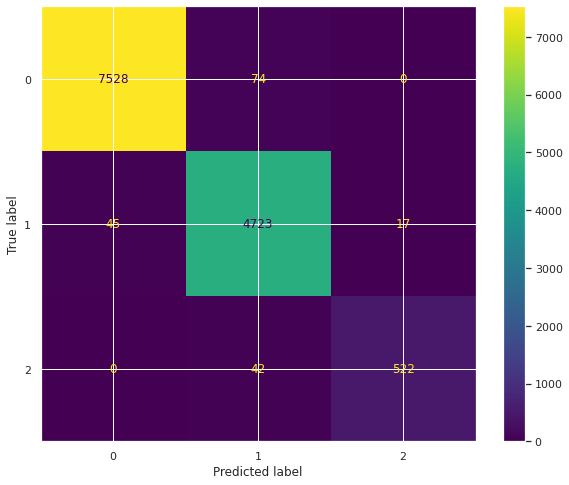

In [71]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)
enn = EditedNearestNeighbours()
#rov = RandomOverSampler()
#smote = SMOTE(random_state=0)
#clf = SVC(gamma='auto',kernel='linear', C = 1.0, random_state = seed) #DecisionTreeClassifier() #
clf = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)

model = make_pipeline(custom_transf,std_scale,pca,enn,clf)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(10,8)})
plot_confusion_matrix(model, sample_val, label_val)  
plt.show()

>>>>>>>init() called.
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.91      0.97      0.94       564

    accuracy                           0.99     12951
   macro avg       0.96      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



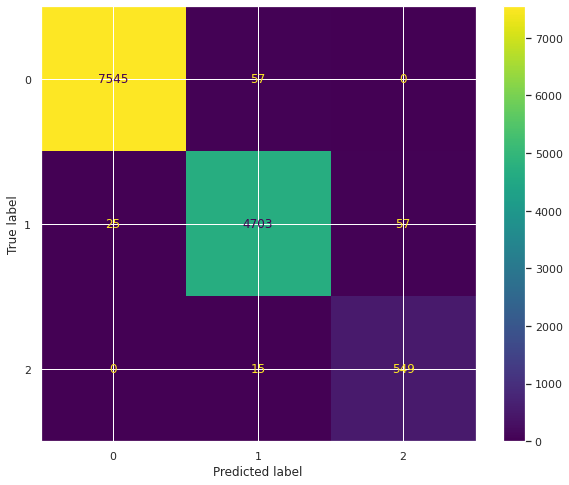

In [72]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)
#enn = EditedNearestNeighbours()
#rov = RandomOverSampler()
smote = SMOTE(random_state=seed)
#clf = SVC(gamma='auto',kernel='linear', C = 1.0, random_state = seed) #DecisionTreeClassifier() #
clf = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)

model = make_pipeline(custom_transf,std_scale,pca,smote,clf)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(10,8)})
plot_confusion_matrix(model, sample_val, label_val)  
plt.show()

>>>>>>>init() called.
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.99      0.98      0.98      4785
           2       0.90      0.97      0.94       564

    accuracy                           0.99     12951
   macro avg       0.96      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



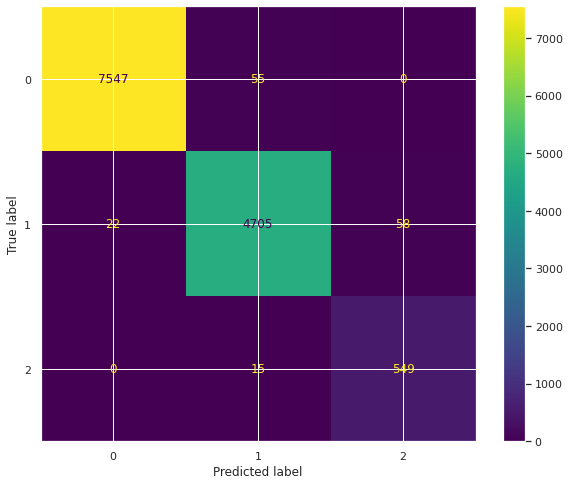

In [75]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)
enn = EditedNearestNeighbours()
rov = RandomOverSampler()
smote = SMOTE(random_state=seed)
#clf = SVC(gamma='auto',kernel='linear', C = 1.0, random_state = seed) #DecisionTreeClassifier() #
clf = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)

model = make_pipeline(custom_transf,std_scale,pca,rov,clf)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(10,8)})
plot_confusion_matrix(model, sample_val, label_val)  
plt.show()

>>>>>>>init() called.
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.99      0.98      0.98      4785
           2       0.90      0.98      0.94       564

    accuracy                           0.99     12951
   macro avg       0.96      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



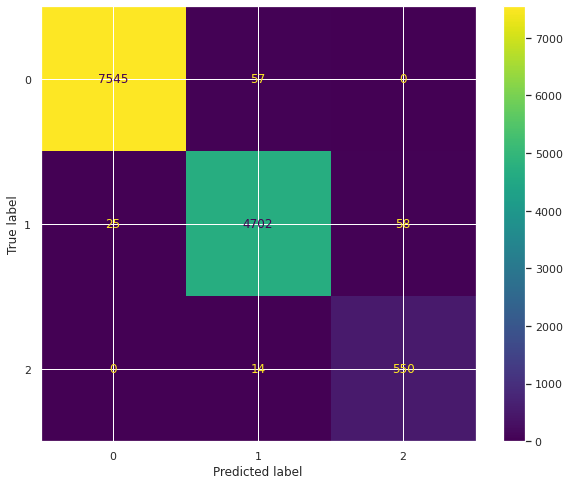

In [76]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)
enn = EditedNearestNeighbours()
rov = RandomOverSampler()
smote = SMOTE(random_state=seed)
#clf = SVC(gamma='auto',kernel='linear', C = 1.0, random_state = seed) #DecisionTreeClassifier() #
clf = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)

model = make_pipeline(custom_transf,std_scale,pca,rov,smote,clf)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(10,8)})
plot_confusion_matrix(model, sample_val, label_val)  
plt.show()